# Fluid modeling

PorePy supports the introduction of multiphase, multicomponent fluids into its models.

This tutorial focuses on relevant mixin-methods and two approaches to modeling of fluid properties:

- Constitutive laws, using mixin classes which define how the function of some property looks like.
  This approach goes hand-in-hand with PorePy's AD framework.
- Externalized computations using the `EquationsOfState` class, which replaces AD and can be populated with some custom or third-party data (like computations from an actual equation of state).

### Table of contents

1. [Basics and default behavior in PorePy (1 phase, 1 component)](#basics-and-default-behavior-in-porepy)
2. [Modeling component and phase context (n-phase, n-component)](#modeling-component-and-phase-context)
3. [Modeling of fluid properties (3-phases, 2-components)](#modeling-of-fluid-properties)
    - [Properties as functions in constitutive-law-mixins (default)](#properties-as-functions-in-constitutive-law-mixins)
    - [EXAMPLE constitutive law mixin for viscosity of 3-phase mixture](#example-constitutive-law-mixin-for-viscosity)
    - [Equation of State approach (advanced)](#equation-of-state-approach)
    - [EXAMPLE EoS approach for density of of 3-phase mixture](#example-eos-approach-for-3-phase-2-component-mixture)
    - [Hybrid approach (advanced)](#hybrid-approach)
4. [Example simulation: flow & transport of 2 components with hybrid fluid modelling](#example-simulation-flow--transport-with-hybrid-fluid-modelling-3-phase-2-component)
5. [Final remarks](#final-remarks)

## Basics and default behavior in PorePy

Fluids can be defined in terms of two contexts: components and phases.

Components are chemical species (e.g., H2O, Co2,...), which can appear in multiple phases (e.g., liquid or gas).

While the number of components is something the modeler chooses naturally, the number (and more importantly type) of phases is
an unknown number in the general thermodynamic sense.
In PorePy, the modeler must define the (maximal) number and types of phases expected in the course of simulations.

The modeling can then be roughly performed in 3 steps:

1. Defining the components in the fluid
2. Defining the expected phases (1 gas phase, 2 liquid phases for example)
3. Introducing a thermodynamic model for fluid properties (densities, viscosities, enthalpies, ...).

> **Note on distinction between fluid, phase and component properties:**
> 
> It makes no sense to talk about the density of a component, say water.
> Liquid and gaseous water have greatly different densities.
> I.e., extensive properties like density and enthalpy are always related to the phase.
> Multiple components can be present in a phase and influence the phase properties.
> Overall properties of fluid mixtures (consisting of multiple components in multiple phases), depend in a clearly defined manner on the respective properties of present phases (usually a weighted sum of phase properties).
>
> PorePy does not focus on a complete description of thermodynamic fluid properties, but only
> on those terms, which appear in flow and transport equations (conservation of mass and energy).
> I.e., they are important since they contribute to the non-linearity of the problem.

The default fluid in PorePy models consists of 1 component, and 1 phase containing that component.
In this simple case, the fluid properties are equal to the (single) phase properties.

The class [FluidMixin](../src/porepy/compositional/compositional_mixins.py#L1042) provides methods for creating and configuring the `fluid` attribute of PorePy models,
and is part of all models available in [porepy.models](../src/porepy/models/).

Legacy implementations provide a simple customization of the single-component without major effort:


In [1]:
import porepy as pp
from porepy.applications.material_values.fluid_values import water

model_params = {
    'material_constants': {
        'fluid': pp.FluidComponent(**water)
    }
}

model = pp.SinglePhaseFlow(model_params)
model.prepare_simulation()

Above code creates the default single-phase, single-component fluid and is ready for simulations right away.
It is compatible with all constitutive laws for single-phase flow found in the [fluid property library](../src/porepy/models/fluid_property_library.py).

In [2]:
print(model.fluid.num_components)
print(model.fluid.num_phases)
print(model.fluid.reference_component.name)

1
1
water


Note that the `FluidMixin` comes with some default implementations of fluid properties, which are covered in a later section,
and which are general to the degree that without some additional work the models are not ready for simulation.
To override those general implementations, constitutive laws must be treated as pure mixins (as intended).
These constitutive laws then represent the thermodynamic model of the fluid.

For customization, they must be on top in the MRO:

In [3]:
class CustomSinglePhaseFlow(
    pp.constitutive_laws.FluidDensityFromPressureAndTemperature,
    pp.SinglePhaseFlow,
):
    """Just for demonstration purpose. Note that the base model has no notion of
    temperature."""
    

## Modeling component and phase context

For customizing the component context, the method we need to override is `get_components`.
For customizing the phase context, we need to override `get_phase_configuration`.

Below example `MyFluid` will model a 2-component, 3-phase fluid, assuming that the simulation
is in pressure and temperature ranges where water and CO2 can separate into two immiscible, liquid-like phases.
This class can be mixed into a custom model to override the default behavior of `FluidMixin`.

In [4]:
from typing import Sequence


class MyFluid(pp.PorePyModel):

    def get_components(self) -> Sequence[pp.FluidComponent]:
        return [
            # Some custom values for a later section.
            pp.FluidComponent(name='H2O', viscosity=1e-3, density=1e3),
            pp.FluidComponent(name='CO2', viscosity=1e-4, density=6e2),
        ]
    
    def get_phase_configuration(
        self, components: Sequence[pp.compositional.ComponentLike]
    ) -> Sequence[tuple[pp.compositional.PhysicalState, str]]:
        # Phases are configured by defining the physical state and a name.
        # The supported physical states are given by the enum object PhysicalState.
        # We return 2 liquid-like phases, and 1 gas-like phase.
        # The two liquid-like phases are named aqueous and non_aqueous.
        return [
            (pp.compositional.PhysicalState.liquid, 'aqueous'),
            (pp.compositional.PhysicalState.liquid, 'non_aqueous'),
            (pp.compositional.PhysicalState.gas, 'gaseous'),
        ]

Each component has an associated overall fraction variable accessible as `component.fraction`.
Each phase has an associated fraction variable *and* a saturation variable, accessible as
`phase.fraction` and `phase.saturation` respectively. The fractions can be either massic or molar and depend on the
implementation of the fluid properties. Saturations are always volumetric fractions.

By default, the first, returned component and phase (configuration) are set as the reference component and phase respectively.
This choice has an impact on both variables and equations created, depending on the model parametrization.

In [5]:
model_params = {
    'eliminate_reference_phase': True,
    'eliminate_reference_component': True,
}

Both parameters are by default `True`. If the reference phase is eliminated,
its [fraction](../src/porepy/compositional/base.py#549) and [saturation](../src/porepy/compositional/base.py#567)
are not introduced as independent variables, but expressed through unity:

$$
\varphi_{r} = 1 - \sum_{i\neq r} \varphi_i
$$

Analogously, if the reference component is eliminated, its [overall fraction](../src/porepy/compositional/base.py#106) is expressed through unity.
Additionally, if the reference component is eliminated, compositional flow models do not introduce a mass balance equation
for the respective component.

We note these effects here but refer to the code in [`porepy.models.compositional_flow`](../src/porepy/models/compositional_flow.py) for more details.

Now that we know how to introduce phases and components into the model, we can talk about the interplay
between the two contexts: Components in a phase.

In general, a component in a phase is associated with an additional degree of freedom, the [`phase.partial_fraction_of[component]`](../src/porepy/compositional/base.py#593).

The behavior of which component is present in which phase is determined by the method `set_components_in_phases`.
Its default behavior introduces every component in every phase (unified assumption).
For fluids, this assumption is realistic since traces of every component can be found in every phase, if that phase is present in the thermodynamic sense (phase appearance/disappearance).
Future work will encompass solid components and solid phases, and expecting a fluid component like water inside a solid phase with granite or sand is nonsense. We can avoid introducing respective DoFs.

To describe that logic, let's assume a special model based on `MyFluid` which we simplify such that each liquid phase contains only an associated component.
We can use it instead of `MyFluid` as a mixin, to override the default implementation of `FluidMixin`.

In [6]:
class MySpecialFluid(MyFluid):

    def set_components_in_phases(
        self, components: Sequence[pp.Component], phases: Sequence[pp.Phase]
    ) -> None:
        h2o, co2 = components
        aqu, non_aqu, gas = phases

        # Aqueous phase contains only water, the non-aqueous only CO2.
        # The gas phase contains both, since gases always mix.
        aqu.components = [h2o]
        non_aqu.components = [co2]
        gas.components = [h2o, co2]

With above mixin `MySpecialFluid`, the two liquid phases will contain only 1 component.
This means that only 1 partial fraction per liquid phase can exist. If only 1 can exist, it is by default the scalar 1.
The gas phase has two partial fractions associated, one for each component. Since the unity constraint holds analogously for partial fractions, the partial fraction of water in the gas phase is eliminated **always**. This is contrary to the phase and overall fractions, where the choice of number of degrees of freedom is relevant to treat the issue of
phase appearance and disappearance.

**To summarize:**

With default model parameters, `MySpecialFluid` will introduce in total 6 degrees of freedom in each subdomain cell:

- 1 overall fraction of CO2
- 2 phase fractions for the non-aqueous and the gas phase (under certain conditions, see later section)
- 2 phase saturations for the non-aqueous and gas phase
- 1 partial fraction for CO2 in the gas phase.

This behavior, including some utility functions, is implemented in the [MixtureDOFHandler](../src/porepy/compositional/compositional_mixins.py#106), which is inherited by the
[CompositionalVariablesMixin](../src/porepy/compositional/compositional_mixins.py#536).
**The `CompositionalVariablesMixin` must be part of any PorePy model with more than 1 phase or component.**

> **Note on phase fractions:**
>
> Phase fractions are quantities which do not usually appear in flow & transport problems, but in phase equilibrium or chemical problems.
> Hence it is not created as a DOF by default, but its creation must be triggered by defining an equilibrium type in the `model_params['equilibrium_type']= 'some_string'`.
>
> They can appear under non-isothermal conditions though, since the specific enthalpy and specific internal energy of the fluid mixture are sums of phase enthalpies/energies weighed with phase fractions.
> With those more complex models, the user must be well aware of the DOFs required and how to create them, and how the (specific) energies are implemented.

> **Note on extended partial fractions:**
>
> PorePy supports formulations of the unified equilibrium problem. It is triggered by including the keyword `'unified'` in `model_params['equilibrium_type']='unified-some-other-keywords'`.
> The unified formulation represents a persistent set of variables, including the so-called extended partial fractions, which are variables also for vanished phases. They are always independent quantities, even in phases with only 1 component.
> They are accessed by [`phase.extended_fraction_of[component]`](../src/porepy/compositional/base.py#581).
>
> In the unified setting, the (physical) partial fractions are always dependent quantities obtained by normalization of extended fractions.


## Modeling of Fluid Properties

Fluid properties, like all other terms entering some equation, are implemented as callables.
They take a sequence of grids (subdomains or boundary grids) and return an AD operator.

Since PorePy allows for a dynamic modeling of phases, these callables must also be handled dynamically.
We achieve this by implementing various "function factories".

### Properties as functions in constitutive-law-mixins

This approach assumes that the fluid property is some analytical expression which can be handled by PorePy's AD framework.

Let's consider the a heuristic law for density of form

$$
\rho(p) = \rho_0 e^{c(p - p_0)}
$$

This density function is already available in the constitutive laws in PorePy and is implemented as follows:

In [7]:
import inspect

print(inspect.getsource(pp.constitutive_laws.FluidDensityFromPressure.density_of_phase))

    def density_of_phase(self, phase: pp.Phase) -> ExtendedDomainFunctionType:
        """Mixin method for :class:`~porepy.compositional.compositional_mixins.
        FluidMixin` to provide a density exponential law for the fluid's phase.

        .. math::
            \\rho = \\rho_0 \\exp \\left[ c_p \\left(p - p_0\\right) \\right]

        The reference density and the compressibility are taken from the material
        constants of the reference component, while the reference pressure is accessible
        by mixin; a typical implementation will provide this in a variable class.

        Parameters:
            phase: The single fluid phase.

        Returns:
            A function representing above expression on some domains.

        """

        def rho(domains: pp.SubdomainsOrBoundaries) -> pp.ad.Operator:
            rho_ref = Scalar(
                self.fluid.reference_component.density, "reference_fluid_density"
            )
            rho_ = rho_ref * self.pressure_expo

We note a couple of things:

1. The method `density_of_phase` takes a `phase` instance and is supposed to return a callable. The callable is implemented locally as `def rho(...)` and the function itself is returned.
2. This constitutive law makes no usage of the argument `phase`. If it is used in a multiphase setup, every phase will get `rho` assigned as it's density function.
3. `rho` uses only the reference density of the `fluid.reference_component`. Other components would have no effect on the density.

With above points it is trivial to conclude, that this particular constitutive law is meant for single-phase, single-component fluids.

There are a couple of such function factories which are defined by the [FluidMixin](../src/porepy/compositional/compositional_mixins.py#1042). All of them can be overwritten with some custom constitutive law.
We mention the most important ones here:

- [density_of_phase](../src/porepy/compositional/compositional_mixins.py#1346)
- [specific_enthalpy_of_phase](../src/porepy/compositional/compositional_mixins.py#1392)
- [viscosity_of_phase](../src/porepy/compositional/compositional_mixins.py#1411)
- [thermal_conductivity_of_phase](../src/porepy/compositional/compositional_mixins.py#1430)

By default, they will return a `no_property_function`, which will raise an error if ever called. This will support the user in the modeling process, drawing attention to the fact that some constitutive law is missing.

Again, by virtue of the mixin framework, constitutive laws must be on top of the MRO in order to override the default implementation.

#### Example constitutive law mixin for viscosity of 3-phase mixture

Let us implement a mixin, which assigns different viscosities for different phases of `MySpecialFluid`:

- constant viscosity of the aqueous phase using some reference value of the water component.
- analogously for the non-aqueous phase using CO2.
- some fictional mixing rule for the gas phase, using the partial fractions.

In [8]:
from typing import Callable


class MyViscosity(pp.PorePyModel):

    # Notice the advanced typing, saying we expect a phase of fluid components.
    # This helps the linter to identify properties of the components in the phases such
    # as viscosity.
    def viscosity_of_phase(
        self, phase: pp.Phase[pp.FluidComponent]
    ) -> pp.compositional.compositional_mixins.ExtendedDomainFunctionType:
        aqu, non_aqu, gas = self.fluid.phases
        h2o, co2 = self.fluid.components

        mu: Callable[[pp.SubdomainsOrBoundaries], pp.ad.Operator]

        if phase in [aqu, non_aqu]:

            def mu(domains: pp.SubdomainsOrBoundaries) -> pp.ad.Operator:
                # The liquid phases have only 1 component, and we wrap its viscosity
                # value.
                return pp.ad.Scalar(phase.components[0].viscosity)

        elif phase == gas:

            def mu(domains: pp.SubdomainsOrBoundaries) -> pp.ad.Operator:
                # Some fictional mixing of viscosity values for demonstration purposes.
                mu_h2o = aqu.viscosity(domains)
                mu_co2 = non_aqu.viscosity(domains)
                return (
                    gas.partial_fraction_of[h2o](domains) * mu_h2o
                    + gas.partial_fraction_of[co2](domains) * mu_co2
                )

        return mu

`MyViscosity` has a method which *creates* callables, which are in return assigned as the attributes `phase.viscosity(domains) -> pp.ad.Operator`.
Such constitutive laws can be implemented analogously for any of the above mentioned phase properties.

### Equation of State approach (advanced)

The equation of state approach is designed for thermodynamic models, which are either too costly to be implemented via AD, or use some external library to compute values and derivative values.

The user must define two things to utilize this approach:

1. Appropriate types of [EquationOfState](../src/porepy/compositional/base.py#340)
2. The formal dependencies of the fluid properties (in above example, $p$ would be a dependency of $\rho$).

Equations of State are designed to operate solely with numerical values, and wrap
computations obtained from e.g., cubic EoS, into the PorePy framework.

**Any kind of computation can be wrapped inside a custom `EquationOfState`-class.**

The single method which must be implemented for the computation of fluid properties is `compute_phase_properties`:

In [9]:
print(inspect.getsource(pp.compositional.EquationOfState.compute_phase_properties))

    def compute_phase_properties(
        self, phase_state: PhysicalState, *thermodynamic_input: np.ndarray
    ) -> PhaseProperties:
        """Method to compute the properties of a phase based any
        thermodynamic input and a given physical state.

        The base class method raises an :obj:`NotImplementedError`.

        Examples:
            1. For a single component mixture, the thermodynamic input may consist of
               just pressure and temperature.
               For isothermal models, it may be just pressure.
            2. For general multiphase-multicomponent mixtures, the thermodynamic input
               may consist of pressure, temperature and partial fractions of components
               in a phase.
            3. For correlations which indirectly represent the solution of the fluid
               phase equilibrium problem, the signature might as well be pressure,
               temperature and independent overall fractions, or other primary flow &
     

We observe that this method takes an arbitrary number of `*thermodynamic_input`.
This input represents the formal dependencies (with above example, a single numpy array would be fed to this method containing pressure values per cell).

These formal dependencies can be defined by the user by providing an override of `dependencies_of_phase_properties`.
The framework will evaluate the dependencies to obtain numpy arrays, and feed them to `compute_phase_properties`.

#### Example EoS approach for density

Let us extend `MySpecialFluid` and illustrate this approach.

For that, we define a liquid EoS and a gas EoS, both computing some simple density values.
We assume the liquid phases to be slightly compressible, and the gas phase compressible with some influence of both components.

In [10]:
import numpy as np


class LiquidEoS(pp.compositional.EquationOfState):
    def __init__(
        self, components: Sequence[pp.FluidComponent], reference_pressure: pp.number
    ):
        super().__init__(components)
        # Store relevant data from the expected component.
        # This EoS expects only 1 component and calculates the density exemplarily using
        # only some value provided by the fluid component.
        assert len(components) == 1
        self._ref_rho = components[0].density
        self._ref_p = reference_pressure

    # NOTE: The signature of this method takes the physical state since an EoS can in
    # general be used for both liquid and gas-like phases.
    def compute_phase_properties(
        self,
        phase_state: pp.compositional.PhysicalState,
        *thermodynamic_input: np.ndarray,
    ) -> pp.compositional.PhaseProperties:
        assert phase_state == pp.compositional.PhysicalState.liquid
        assert len(thermodynamic_input) == 1
        # p is a 1D array with pressure values per cell.
        # It is obtained by p = equation_system.evaluate(self.pressure(domains))
        # This evaluation is performed by the framework before calling this method.
        p = thermodynamic_input[0]

        # Proceed with computations of properties using stored component data.
        # Mimicing slightly compressible density
        rho = np.ones_like(p) * self._ref_rho * 1e-6 * (p - self._ref_p)
        # The framework expects that derivatives of rho w.r.t. pressure are provided.
        drho = np.ones_like(p) * self._ref_rho * 1e-6
        # Derivatives expect rows per dependency. I.e., we must reshape drho.
        drho = drho.reshape((1, drho.shape[0]))

        # NOTE The class PhaseProperties takes many more data, including data for
        # non-isothermal settings.
        # For the purpose of this tutorial, we compute only the density.
        return pp.compositional.PhaseProperties(
            state=phase_state,
            rho=rho,
            drho=drho,
        )


class GasEoS(pp.compositional.EquationOfState):
    def __init__(
        self, components: Sequence[pp.FluidComponent], reference_pressure: pp.number
    ):
        super().__init__(components)
        # Store relevant data from the expected components.
        assert len(components) == 2
        self._ref_rhos = [c.density for c in components]
        self._ref_p = reference_pressure

    def compute_phase_properties(
        self,
        phase_state: pp.compositional.PhysicalState,
        *thermodynamic_input: np.ndarray,
    ) -> pp.compositional.PhaseProperties:
        assert phase_state == pp.compositional.PhysicalState.gas
        assert len(thermodynamic_input) == 2
        p, z_CO2 = thermodynamic_input
        z_H2O = 1.0 - z_CO2
        p_ref = 0.0

        # Some fictional mixing for density of gas, depending on pressure and fraction
        # of CO2.
        rho = z_H2O * self._ref_rhos[0] * (p - self._ref_p) + z_CO2 * self._ref_rhos[
            1
        ] * (p - p_ref)

        # Computing the derivatives w.r.t. the two dependencies.
        drho_dp = z_H2O * self._ref_rhos[0] + z_CO2 * self._ref_rhos[1]
        drho_dzCO2 = self._ref_rhos[1] * (p - self._ref_p) - self._ref_rhos[0] * (
            p - self._ref_p
        )

        # drho contains derivatives w.r.t. pressure in the first row and w.r.t. co2
        # fraction in the second row.
        drho = np.zeros((2, p.shape[0]))
        drho[0, :] = drho_dp
        drho[1, :] = drho_dzCO2

        return pp.compositional.PhaseProperties(
            state=phase_state,
            rho=rho,
            drho=drho,
        )


# Now we define a fluid, where the properties of the liquid phases depend only on
# pressure, and the properties of the gas phase depend on pressure and the fraction of
# CO2.
class MyVerySpecialFluid(MySpecialFluid):
    pressure: Callable[[pp.SubdomainsOrBoundaries], pp.ad.Variable]
    temperature: Callable[[pp.SubdomainsOrBoundaries], pp.ad.Variable]

    # NOTE: This method needs to be overridden to define what the *thermodynamic_input
    # for our EoS computations are.
    # For the AqueousEoS and NonAqueous, it will be
    # *thermodynamic_input = (pressure_array,)
    # For the GasEoS it will be
    # *thermodynamic_input = (pressure_array, co2_fraction_array)
    def dependencies_of_phase_properties(
        self, phase: pp.Phase
    ) -> Sequence[Callable[[pp.GridLikeSequence], pp.ad.Variable]]:
        aqu, non_aqu, gas = self.fluid.phases
        _, co2 = self.fluid.components

        if phase in [aqu, non_aqu]:
            return [self.pressure]
        elif phase == gas:
            return [self.pressure, co2.fraction]
        else:
            raise ValueError

    # We add the EoS to the phase configuration to inform the framework about the
    # externalized computations.
    def get_phase_configuration(
        self, components: Sequence[pp.compositional.ComponentLike]
    ) -> Sequence[
        tuple[pp.compositional.EquationOfState, pp.compositional.PhysicalState, str]
    ]:
        h2o, co2 = components
        ref_p = self.reference_variable_values.pressure

        eos_aqu = LiquidEoS([h2o], ref_p)
        eos_nonaqu = LiquidEoS([co2], ref_p)
        eos_gas = GasEoS(components, ref_p)
        # We can configure phases by also passing an Equation of State.
        # It does not have to be an EoS per phase. Phases can also share the EoS object.
        # The return type of changes and we return the EoS as the first tuple element.
        return [
            (eos_aqu, pp.compositional.PhysicalState.liquid, "aqueous"),
            (eos_nonaqu, pp.compositional.PhysicalState.liquid, "non_aqueous"),
            (eos_gas, pp.compositional.PhysicalState.gas, "gaseous"),
        ]

**Again**, the EoS class can in principle wrap any kind of computation or call to external libraries.
In above example EoS, we are obviously shooting with cannons on sparrows. It would have been much simpler (and more efficient!) to implement these calculations similar the same way we implemented `MyViscosity`. This is just for demonstration purposes.

Using `MyVerySpecialFluid`, any phase property $\psi$ of the aqueous and non-aqueous phase will have a signature

$$
\psi_a = \psi_a(p)
~,~
\psi_{na} = \psi_{na}(p),
$$

and analogously for the gas phase it will be $\psi_g = \psi_g(p, z_{CO2})$.

By providing respective Equations of state, `*thermodynamic_input` will be a tuple containing an array of pressure values, or two arrays of pressure and CO2-fraction values respectively.

Under the hood, the `FluidMixin` will detect that formal dependencies of phase properties are defined.
If so, **every** phase property will be instantiated as a [SurrogateFactory](../src/porepy/numerics/ad/surrogate_operator.py#360).
The values and derivative values of the respective [SurrogateOperators](../src/porepy/numerics/ad/surrogate_operator.py#141) will be populated with the results of the respective Equation of state.

> **Note on formal dependencies:**
>
> The dependencies declared by `dependencies_of_phase_properties` must be variables in the mathematical and AD sense.
> Such quantities have identity blocks in their `.jac` attributes when parsed. The indices of these identity blocks are used by the framework to insert derivative values returned by the EoS into the global Jacobian.
> This would not work with general AD operators/ non-variables, since they have multiple entries per row in `.jac`.

### Hybrid approach

It is also possible to mix the two approaches, using an EoS for some properties, and using mixins as constitutive laws for others.

Use cases include situations where some quantities are not readily available from an EoS, or can be simplified without introducing a large modelling error. Notably, viscosity and thermal conductivity are such quantities, which in many EoS are treated as secondary state functions in the thermodynamic sense.

**Important:**
When using the hybrid approach, constitutive laws which are supposed to overwrite the
behavior of the EoS must **strictly** be above the customized fluid (again, keyword mixins).
Also, if the modeller defines `depencencies_of_phase_properties`, the `FluidMixin` will turn **all** phase properties by default in `SurrogateFactory` objects.
If that is not intended, it might be necessary to override some of them (even if not used in the PDEs!) with some mixin.

We now have everything to define a flow & transport model with our complex fluid.

## Example simulation: flow & transport with hybrid fluid modelling (3-phase, 2-component)

Let us define a flow & transport model with `MyVerySpecialFluid`, which has a custom viscosity law for each phase using the `MyViscosity` mixin, and externalized computations for densities using our EoS, which are stored in the phases of the fluid.

In [11]:
class ConstitutiveLaws(
    # General constitutive laws required for flow & transport.
    pp.compositional_flow.ConstitutiveLawsSolidSkeletonCF,
    pp.constitutive_laws.FluidMobility,
    pp.constitutive_laws.ZeroGravityForce,
    pp.constitutive_laws.SecondOrderTensorUtils,
    pp.constitutive_laws.FouriersLaw,
    pp.constitutive_laws.DimensionReduction,
    pp.constitutive_laws.AdvectiveFlux,
    pp.constitutive_laws.DarcysLaw,
    pp.constitutive_laws.PeacemanWellFlux,
    # NOTE IMPORTANT: Due to the EoS being used, we must override even those properties
    # with constitutive laws, which are not formally used by the model.
    # This tells the model to disregard the computations of phase properties by the
    # EoS, for which there already are mixed in constitutive laws.
    pp.constitutive_laws.ThermalConductivityCF,
    pp.constitutive_laws.EnthalpyFromTemperature,
): ...


class MyCompositionalFlowModel(
    # Required constitutive laws
    ConstitutiveLaws,
    # MyViscosity above MyVerySpecialFluid
    MyViscosity,
    MyVerySpecialFluid,
    # Variables for flow & transport.
    pp.fluid_mass_balance.VariablesSinglePhaseFlow,
    pp.compositional.CompositionalVariables,
    # Equations for flow & transport.
    pp.compositional_flow.ComponentMassBalanceEquations,
    pp.fluid_mass_balance.FluidMassBalanceEquations,
    # For BC, IC and solution strategy, we need the mixins for phase properties, which
    # are represented by SurrogateFactories and EoS. We also need those for fractions in
    # the multicomponent setting, and the ones for single phase flow, which is takes
    # care of anything pressure related.
    pp.compositional_flow.BoundaryConditionsPhaseProperties,
    pp.compositional_flow.BoundaryConditionsMulticomponent,
    pp.fluid_mass_balance.BoundaryConditionsSinglePhaseFlow,
    pp.compositional_flow.InitialConditionsPhaseProperties,
    pp.compositional_flow.InitialConditionsFractions,
    pp.fluid_mass_balance.InitialConditionsSinglePhaseFlow,
    pp.compositional_flow.SolutionStrategyPhaseProperties,
    pp.fluid_mass_balance.SolutionStrategySinglePhaseFlow,
    pp.FluidMixin,
    pp.ModelGeometry,
    pp.DataSavingMixin,
):
    # Defining left-to-right flow with Dirichlet-type data for pressure
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        domain_sides = self.domain_boundary_sides(sd)
        return pp.BoundaryCondition(sd, domain_sides.west + domain_sides.east, "dir")

    def bc_type_fluid_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        return self.bc_type_darcy_flux(sd)

    def bc_values_pressure(self, bg: pp.BoundaryGrid) -> np.ndarray:
        # Inflow from the left
        values = np.zeros(bg.num_cells)
        sides = self.domain_boundary_sides(bg)
        values[sides.west] = self.reference_variable_values.pressure + 2
        values[sides.east] = self.reference_variable_values.pressure
        return values

    def bc_values_overall_fraction(
        self, component: pp.Component, bg: pp.BoundaryGrid
    ) -> np.ndarray:
        # IC and BC value methods for fractions are only called for independent
        # components! Zero values are returned by default, meaning the domain is
        # initially water-saturated, and flushed with CO2 from the left
        assert component.name == "CO2"
        values = np.zeros(bg.num_cells)
        sides = self.domain_boundary_sides(bg)
        values[sides.west] = 1.0
        return values

    def ic_values_pressure(self, sd: pp.Grid) -> np.ndarray:
        # Initial pressure value equals to reference value.
        return (self.reference_variable_values.pressure + 1) * np.ones(sd.num_cells)

    # Since we have 2 saturation variables and 1 partial fraction variable which
    # are dangling, we close the system with some pseudo-equilibrium.
    # NOTE: This is just for illustration purposes!! It does not represent any
    # serious phase transition modelling.
    def set_equations(self):
        super().set_equations()
        subdomains = self.mdg.subdomains()

        for phase in self.fluid.phases:
            # Distribute masses equally accross phases
            if self.has_independent_saturation(phase):
                equ = phase.saturation(subdomains) - pp.ad.Scalar(1 / 3)
                equ.set_name(f"pseudo_phase_split_{phase.name}")
                self.equation_system.set_equation(equ, subdomains, {"cells": 1})

            # For the gas phase, which has two components, we say that half of the mass
            # of the independent component in the reference phase, undergoes phase
            # change and appears in the gas phase.
            if len(phase.components) > 1:
                for component in phase:
                    if self.has_independent_partial_fraction(component, phase):
                        equ = phase.partial_fraction_of[component](
                            subdomains
                        ) - pp.ad.Scalar(1 / 2)
                        equ.set_name(
                            f"pseude_k_value_equation_{component.name}_{phase.name}"
                        )
                        self.equation_system.set_equation(equ, subdomains, {"cells": 1})

    # Since saturations and partial fractions appear in the non-linear terms in the
    # advective fluxes, they need boundary values as well.
    # We enforce here exemplarily only the target values of our pseudo-equilibrium.
    def update_all_boundary_conditions(self):
        super().update_all_boundary_conditions()

        sds = self.mdg.subdomains()

        for phase in self.fluid.phases:
            if self.has_independent_saturation(phase):

                def s_bc(bg: pp.BoundaryGrid) -> np.ndarray:
                    return np.ones(bg.num_cells) * 1 / 3

                self.update_boundary_condition(phase.saturation(sds).name, s_bc)

            for comp in phase:
                if self.has_independent_partial_fraction(comp, phase):
                    # We know that only CO2 in the gas phase has an independent
                    # partial fraction
                    def x_bc(bg: pp.BoundaryGrid) -> np.ndarray:
                        return np.ones(bg.num_cells) * 1 / 2

                    self.update_boundary_condition(
                        phase.partial_fraction_of[comp](sds).name, x_bc
                    )


model = MyCompositionalFlowModel(
    {
        "meshing_arguments": {
            "cell_size": 0.2,
        },
        "material_constants": {
            "solid": pp.SolidConstants(permeability=1e-5, porosity=0.1),
        }
    }
)
# Creates the fluid.
model.prepare_simulation()

First, let's assert that the degrees of freedom are as we expect:

In [12]:
sds = model.mdg.subdomains()
print(
    "Overall fraction is variable:",
    [
        (comp.name, isinstance(comp.fraction(sds), pp.ad.Variable))
        for comp in model.fluid.components
    ],
)
print(
    "Saturation is variable:",
    [
        (phase.name, isinstance(phase.saturation(sds), pp.ad.Variable))
        for phase in model.fluid.phases
    ],
)

for phase in model.fluid.phases:
    print("---")
    print(f"{phase.name} phase:")
    print(
        "Partial fraction is variable:",
        [
            (
                comp.name,
                isinstance(phase.partial_fraction_of[comp](sds), pp.ad.Variable),
            )
            for comp in phase
        ],
    )

Overall fraction is variable: [('H2O', False), ('CO2', True)]
Saturation is variable: [('aqueous', False), ('non_aqueous', True), ('gaseous', True)]
---
aqueous phase:
Partial fraction is variable: [('H2O', False)]
---
non_aqueous phase:
Partial fraction is variable: [('CO2', False)]
---
gaseous phase:
Partial fraction is variable: [('H2O', False), ('CO2', True)]


Since we have no equilibrium type defined, phase fractions are not introduced.
Calling them will raise an error:

In [13]:
try:
    model.fluid.reference_phase.fraction(sds)
except pp.compositional.CompositionalModellingError as err:
    print(err)

Phase fractions are not defined in model without equilibrium. A re-formulation using saturations is required.


Finally, let's see if the viscosities are as we expect, and not Surrogate Operators, as they would be when using EoS calculations for them.
Densities on the other hand, must be surrogate operators, since we have no constitutive law mixed in for them.

In [14]:
aqu, non_aqu, gas = model.fluid.phases

for phase in model.fluid.phases:
    print('---')
    print(f"{phase.name} phase:")
    mu = phase.viscosity(sds)
    mu_val = model.equation_system.evaluate(mu)
    print('Type and value of viscosity:', type(mu), mu_val)
    rho = phase.density(sds)
    rho_val = model.equation_system.evaluate(rho)
    print('Type and value of density:', type(rho), rho_val)

---
aqueous phase:
Type and value of viscosity: <class 'porepy.numerics.ad.operators.Scalar'> 0.001
Type and value of density: <class 'porepy.numerics.ad.surrogate_operator.SurrogateOperator'> [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001]
---
non_aqueous phase:
Type and value of viscosity: <class 'porepy.numerics.ad.operators.Scalar'> 0.0001
Type and value of density: <class 'porepy.numerics.ad.surrogate_operator.SurrogateOperator'> [0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006
 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006 0.0006
 0.0006 0.0006 0.0006 0.0006 0.0006]
---
gaseous phase:
Type and value of viscosity: <class 'porepy.numerics.ad.operators.Operator'> [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001]
Type and value of density:

Since we have trivial IC values, the fraction of CO2 in the gas phase is zero, and the fraction of water in the gas phase is by unity equal to 1. Therefore, the viscosity of the gas phase is equal the viscosity of the pure water phase.
Furthermore, since pressure is 1 initially, the densities in the liquid phases are equal to the ones assigned as reference values per component, scaled with $1e-6$ respectively.
And since the fraction of CO2 is equal to zero initially, the density of the gas phase with the mixing rule implemented in `GasEoS` returns the density of water only.

In [15]:
pp.run_time_dependent_model(
    model,
    {
        "prepare_simulation": False,
        "max_iterations": 50,
        "nl_convergence_tol": 1e-15,
        "nl_convergence_tol_res": 1e-15,
    }
)

We run the model using the default time stepping configurations (1 second with `dt=1`) and inspect the overall fraction, gas saturation, and pressure profile.

Due to upwinding and implicit Euler, the scheme is diffusive and we observe a gradient in the CO2 fraction.

The gas saturation is, as modelled by the pseudo-equilibrium, `1/3`.

The pressure profile indicates a left to right flow, with a gradient droping from 2 to 0.

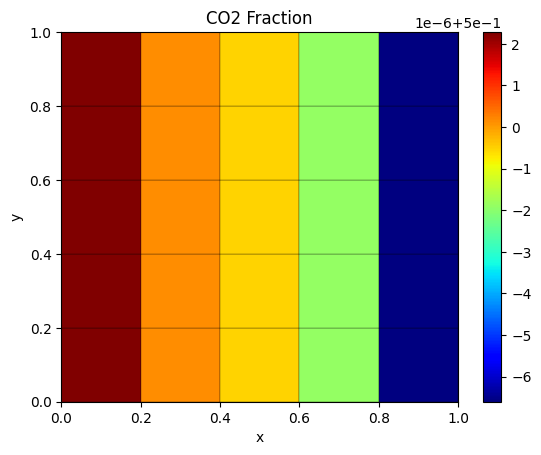

In [16]:
pp.plot_grid(
    model.mdg,
    "z_CO2",
    figsize=(10, 8),
    linewidth=0.2,
    title='CO2 Fraction',
    plot_2d=True,
)

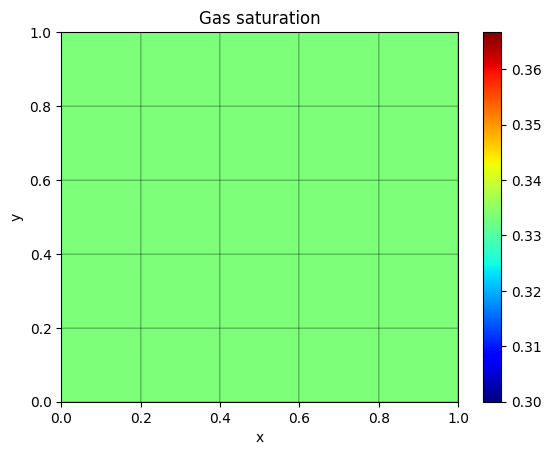

In [17]:
pp.plot_grid(
    model.mdg,
    "s_gaseous",
    figsize=(10, 8),
    linewidth=0.2,
    title='Gas saturation',
    plot_2d=True,
)

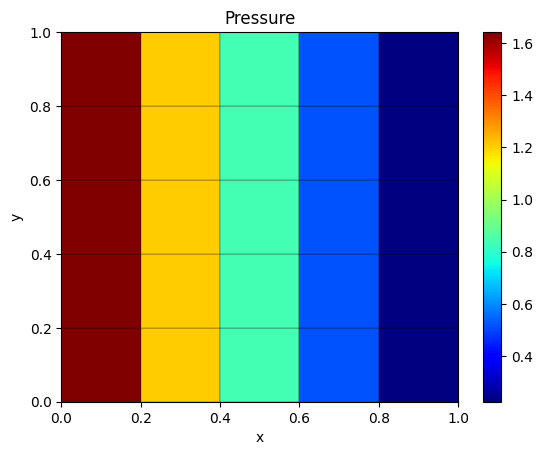

In [18]:
pp.plot_grid(
    model.mdg,
    "pressure",
    figsize=(10, 8),
    linewidth=0.2,
    title='Pressure',
    plot_2d=True,
)

## Final remarks

What we have explored:

- How to set up a model with multiple components and\or multiple phases.
- How to write constitutive laws for thermodynamic properties, if multiple phases are involved.
- How to externalize computations of thermodynamic properties using the `EquationOfState` class.
- How to define what the input for the external computations is.
- How to model fluids using both, mixed in constitutive laws and externalized computations, with special emphasis on the order of mixins in the hybrid approach.
- How to deal with the increasing complexity in terms of DOFs, and what is required to close the system (including IC and BC values).
- Where to find mixins for transport equations, especially those handling the automatized update of phase properties using external calculations.

We emphasize again, that when modelling complex fluids and their properties, a familiarity with the introduced variables is required, and where they appear in the PDEs (f.e. do I need BC values for the new variables?).
Thorough knowledge about the mixin framework is also required for advanced usage of PorePy's capabilities.

Common pitfalls:

- Unawareness of the variables introduced by setting different components in different phases.
- Improper definition of `dependencies_of_phase_properties` when using some derived classes of `EquationOfstate`.
- Faulty/ missing implementations of derivatives of phase properties when using external calculations, often result in an unintended Quasi-Newton approach with an inexact Jacobian.
- Using the EoS approach, and not being aware that the model must be informed on how to deal with thermodynamic properties, which are **not** part of the externalized computations (use some mixins to avoid creating redundant `SurrogateFactory`s).
- Forgetting BC values for the fractional variables, which require now a dynamic way of thinking about respective methods (see `def s_bc` and `def x_bc`)
- Transport problem: Depending on how strong the non-linearity is introduced by an EoS, a proper tuning of the time stepping algorithm is required, depending on domain size, refinement and permeability. Blindly using `pp.run_timedependen_model` will likely result in failure.

